In [1]:
println("Hello World")

Hello World


In [3]:
using PyPlot, Random, FFTW
using CSV, DataFrames

In [4]:
nx, ny = 128, 128 # number of grid points
Lx, Ly = 20.0*pi, 20.0*pi      # size of the domain in each direction

(62.83185307179586, 62.83185307179586)

In [5]:
dx, dy = Lx/nx, Ly/ny
x = 0:dx:Lx-dx
y = 0:dy:Ly-dy

0.0:0.4908738521234052:62.340979219672455

In [6]:
X  = zeros(nx,ny)
Y  = zeros(nx,ny)
for j in 1:ny, i in 1:nx
     X[i, j] = x[i]
     Y[i, j] = y[j]
end

In [7]:
k  = 2.0*pi/Lx * [0:nx/2; -nx/2+1:-1];
l  = 2.0*pi/Ly * [0:ny/2; -ny/2+1:-1];

K = zeros(nx, ny)
L = zeros(nx, ny)
for j in 1:ny, i in 1:nx
    K[i, j] = k[i]
    L[i, j] = l[j]
end

In [37]:
ksq = @. K^2 + L^2
kqt = ksq .^2

invksq = 1 ./(1 .+ ksq)    # this is used to obtain streamfunction ψ from vorticity ζ
replace!(invksq,Inf=>1);

nu = 3.0e-3       # kinematic viscosity coefficient (you can also use nu=8.0e-05 for n=128)
dt = 0.025         # the time step
tfin = 500        # the final time for the integration
nstep  = Int(tfin/dt) + 1;  # the total number of time steps
kappa = 3e-04
t = 0:dt:tfin;

In [14]:
Random.seed!(1234)


psi0 = randn(nx, ny) #calcula as condições iniciais
psih = fft(psi0) #faz o fourier das condições iniciais
psih[1, 1] = 0
psih[@. ksq > (10)^2 ] .= 0
psih[@. ksq < (3)^2 ] .= 0

phih = invksq.*psih #calcula $phi=psi/(1-k^2)
psi =  real(ifft(psih)) #calcula psi da inversa de fourier
u = real(ifft(+im*L.*phih))     # calculate u velocity u(x,y,t)
v = real(ifft(+im*K.*phih))     # calculate v velocity v(x,y,t)
time = 0
nc = Int(nx/32)
phi = real(ifft(phih))

128×128 Matrix{Float64}:
  0.00689159  -0.0465096    -0.000191762  …  -0.011594    -0.0566983
 -0.0556221   -0.0329642     0.0140775        0.0325824    0.00409267
  0.0322246    0.039212     -0.0558616        0.0269592    0.0245873
  0.0306759    0.0213099    -0.0544108       -0.0403442   -0.0370843
  0.0109772    0.0075708    -0.0228803       -0.0107281    0.0483046
 -0.0333533    0.00254946   -0.0574832    …  -0.0250001   -0.0445644
  0.0663325   -0.0518174     0.0179778       -0.0260121   -0.0205889
  0.0601572   -0.0200507     0.0444344        0.0305275    0.0476098
 -0.0142979   -0.0366204     0.0560213        0.024912     0.00380672
 -0.0762972   -0.0313885    -0.0116614        0.0481776   -0.0293446
 -0.00291781   0.0271264    -0.036384     …  -0.0521254    0.00531382
  0.0406106    0.028681     -0.0307559       -0.00431161   0.10198
 -0.00517499  -0.0520181    -0.0203377        0.00060002   0.0302287
  ⋮                                       ⋱               
  0.0100105    0.0

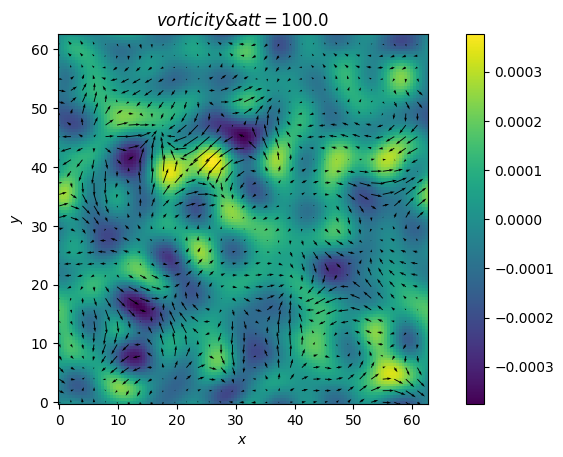

In [38]:
Random.seed!(2234)
dt = 0.025         # the time step
tfin = 100        # the final time for the integration
nstep  = Int(tfin/dt) + 1;  # the total number of time steps
kappa = 3e-04
t = 0:dt:tfin;
kl = 0
ku = 0.8
phi0h = 0.2 .*exp(-im*rand(nx, ny)) #calcula as condições iniciais
phih = phi0h #faz o fourier das condições iniciais
#psih[1, 1] = 0
phih[@. ksq > (ku)^2 ] .= 0
phih[@. ksq < (kl)^2 ] .= 0

#psih = invksq.*psih
phi = real(ifft(phih))

figure(1)
pcolormesh(X, Y, phi)
colorbar()
quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
xlabel(L"x")
ylabel(L"y")
title(string(L"vorticity &  at t=", time))
axis("square")
draw();

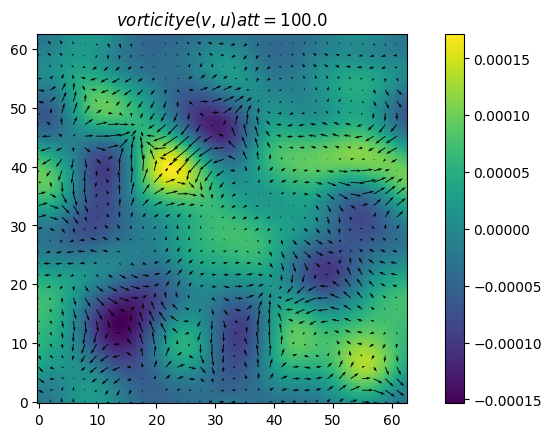

In [39]:
nu = 3e-1
vu = 0.0
time = 0
nc = Int(nx/32)
phi = real(ifft(phih))


fig = figure()

phibk = phi
for j = 2:nstep 
    #phih = invksq.*psih               # calculate \hat{phi}
    psih = phih.*(1 .+ksq)
    u = real(ifft(+im*L.*phih))         # calculate u velocity
    v = real(ifft(+im*K.*phih))         # calculate v velocity
    psix =  real(ifft(im*K.*psih))    # calculate ∂psi/∂x
    psiy =  real(ifft(im*L.*psih))    # calculate ∂psi/∂y

    # now we are ready to calculate the r.h.s. of our PDE
    rhs = -fft(u.*psix - v.*psiy) -vu*fft(v)-nu*kqt .*phih

    
    psih = psih + dt*rhs         # time-step forward using the simplest Euler scheme
    phibk = real(ifft(phih))
    phih = invksq.*psih
    phi = real(ifft(phih))
    if any(isnan, phi)
           println("Entrou")
            println(j)
            println(phibk)
            break
        end
    
    if j % 200 == 1
        time = t[j]
        #phih = -invksq.*psih
        #phi = real(ifft(phih))
        #CSV.write("dados_.csv",DataFrame(psi,:auto),header=false)
        pcolormesh(X, Y, phi)
        #contour(X, Y, phi)
        title(string(L"vorticity at t=", time))
        colorbar()
        quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
        #xlabel(L"x")
        #ylabel(L"y")
        title(string(L"vorticity e (v,u) at t=", time))
        axis("square")
        sleep(0.05)
        IJulia.clear_output(true)
        display(fig)
        clf()
end
end

In [26]:
Random.seed!(1234)
0.2.*exp(-im*rand(nx, ny))

128×128 Matrix{ComplexF64}:
    0.335318+0.0725258im    …    -0.014396-0.0706457im
   0.0900589+0.0195123im         0.0425513+0.0750761im
    0.103502-0.0203258im        -0.0430563-0.0285414im
     -0.0529+0.136721im          0.0880871-0.14703im
    0.186672+0.0733183im         -0.295429-0.0816863im
    0.109166-0.170083im     …  -0.00488838+0.0396049im
     0.13989-0.0145853im        0.00570453+0.148739im
   0.0931611-0.288034im            0.22189+0.129131im
 -0.00045751-0.167352im          -0.183217-0.0523654im
   0.0997479-0.139306im         -0.0295377-0.00689845im
   -0.104115-0.0673781im    …    0.0969713+0.170934im
  -0.0474494+0.0717831im         -0.085737-0.0649837im
    0.201429-0.156825im         -0.0170786-0.079093im
            ⋮               ⋱  
    -0.12725+0.177837im          -0.049463-0.106162im
    0.062658+0.120859im          0.0260464+0.161803im
   -0.249954+0.105703im           0.133106-0.377604im
   0.0490462-0.127994im          0.0320676-0.131062im
   0.0706424-0

In [34]:
pi

π = 3.1415926535897...